## __GAN from scratch__
____
### __Game plan:__ 
1) __Dataset -> MNIST__

2) __Tips:__ 
* [x] Change value of pixels to be between -1 or 1 and float32 type
* [x] Smoothing labels to 0.9 - 1.0 for real images and 0 - 0.1 for fake to train the discrimator
* [x] Adam's momentum parameter set to 0.5 improves stability 
* [x] Noise labels with 5% probability
* [x] Gaussian distribution instead of uniform distribution
* [x] Batch Normalization 
* [x] Conv2D Transpose 

3) __Hyperparameters:__ 
* Batch size -> 32 - 256
* Epochs -> 1000
* Optimizer
    * Adam with lr = 2e-4
* Network
    * Discriminator -> 128, 64, 32, 1
    * Generator -> 32, 64, 128, 784(28*28)
    * DCGAN: 
        * G : 1024, 512, 256, 128
        * D : 128, 256, 512, 1024
* Layers
    * Dropout -> 0.3, default for Discrimnator
    * Batch Normalization 
* Activation function
    * LeakyRelu for all hidden layers -> alpha = 0.2 for Discrimnator
    * Tanh for output layer for generator -> scales output to -1,1 instead of 0,1
    * Relu for generator -> NO 
* Loss function
    * Discrimator -> 0.5(l_real + l_fake)
    * Generator -> target value is 1 for each fake
* Latent space size z = 100 or 128


4) __Traning:__ 
* Discrimator -> freeze generator 
    * Train on batch of real examples with labels  
    * Generate batch of fake examples with labels and train on them
    * Backprop and add both loss functions 
* Generator -> freeze discriminator
    * Batch of fake images with labels  
    * Discrimnator Loss on fake images
    * Backprop of generator model using discrimator loss 

5) __Graphs:__
* Loss function 
* Tracing propability of detecting whether is real or fake for discriminator 
* TESTS: 
    * No dense at the output -> lower resolution, almost black
    * 2 Dense output layers -> a lot of noice, almost white images 
    * No dropout layers in Discriminator -> lower resolution
    * ReLU in Generator -> lower resolution, lots of noice
    * G : {128, 256}, D: {128, 256} instead of G: {128, 64}, D: {64, 128} 
    * Batch Normalization only in Generator -> sharper, clean, better resolution
    * No Dense layer in Generator -> white images, lots of noise
    * Both Discriminator and Generator should have the same networks
    * Twisting: 
        * Batch -> 32, __64__, 128, __256__
        * Latent space -> 100, 128
        * Optimizer -> either 1e-4 or 2e-4
        * 
    
6) __References:__ 
* https://github.com/tdrussell/IllustrationGAN
* https://towardsdatascience.com/gan-ways-to-improve-gan-performance-acf37f9f59b
* https://aylien.com/blog/introduction-generative-adversarial-networks-code-tensorflow
* ALL MININBATCH DISCRIMINATION ABOVE ^
* https://stackoverflow.com/questions/60553795/random-noise-for-gan -> random noise 
* 

In [5]:
import numpy as np 
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Dropout, BatchNormalization as BN, LeakyReLU, Flatten, Dense, Reshape, ReLU, InputLayer
from tensorflow.keras.optimizers import Adam
from tqdm import tqdm
from tensorflow.keras.utils import plot_model

Digit  : 1, Occurance : 6742


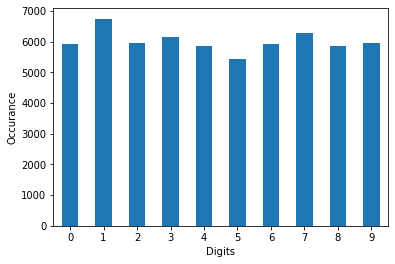

In [8]:
y = [np.count_nonzero(label == i) for i in range(0,10)]
plt.bar([i for i in range(0,10)], y, width = 0.5)
plt.xlabel('Digits')
plt.ylabel('Occurance')
plt.xlim(-0.5,9.5)
plt.xticks([i for i in range(0,10)])
print('Digit  : {}, Occurance : {}'.format(np.argmax(y), np.max(y)))

In [25]:
(real, label), (_, _) = mnist.load_data()
dataset = (real[np.where(label == 8)] - 127.5).astype(np.float32) / 127.5

In [26]:
dataset.shape

(5851, 28, 28)

In [115]:
class Discriminator:
    def __init__(self, lr, input_shape):
        self.lr = lr
        self.input_shape = input_shape
        self.d = self.model() 
        
    def model(self):
        Model = Sequential()
        Model.add(Conv2D(filters = 32, kernel_size = (5,5), strides = (1,1), padding = 'same', input_shape = self.input_shape))
        Model.add(LeakyReLU(alpha = 0.2))
        Model.add(Dropout(0.3))        
        
        Model.add(Conv2D(filters = 64, kernel_size = (5,5), strides = (2,2), padding = 'same'))
        Model.add(LeakyReLU(alpha = 0.2))
        Model.add(Dropout(0.3))
        
        Model.add(Conv2D(filters = 128, kernel_size = (5,5), strides = (2,2), padding = 'same'))
        Model.add(LeakyReLU(alpha = 0.2))
        Model.add(Dropout(0.3))
    
    
        Model.add(Flatten())
        
        Model.add(Dense(1, activation = 'sigmoid'))
        Model.compile(optimizer = Adam(lr = self.lr, beta_1 = 0.5), loss = 'binary_crossentropy')
        
        print(Model.summary())

        return Model
    
class Generator:
    def __init__(self, lr, input_shape, latent_dim):
        self.lr = lr
        self.latent_dim = latent_dim 
        self.output_shape = input_shape
        self.g = self.model()
        
    def model(self):
        Model = Sequential()
        Model.add(Dense(7*7*self.latent_dim, input_dim = self.latent_dim))
        Model.add(LeakyReLU(alpha = 0.2))
        
        Model.add(Reshape((7,7,self.latent_dim)))
        Model.add(Conv2DTranspose(128, kernel_size = (5,5), strides = (2,2), padding = 'same'))
        Model.add(BN())
        Model.add(LeakyReLU(alpha = 0.2))

        Model.add(Conv2DTranspose(64, kernel_size = (5,5), strides = (2,2), padding = 'same'))
        Model.add(BN())
        Model.add(LeakyReLU(alpha = 0.2))

        Model.add(Conv2DTranspose(32, kernel_size = (5,5), strides = (1,1), padding = 'same'))
        Model.add(BN())
        Model.add(LeakyReLU(alpha = 0.2))

        Model.add(Conv2DTranspose(1, kernel_size = (5,5), padding = 'same', activation = 'tanh'))   
        Model.add(Flatten())
        Model.add(Reshape(self.output_shape))
        
        print(Model.summary())
        
        return Model
    
class GAN:
    def __init__(self, dataset, epochs = 1000, batch = 64, latent_dim = 100, lr = 2e-4):
        self.epochs = epochs 
        self.batch = batch 
        self.latent_dim = latent_dim
        self.lr = lr 
        self.dataset = dataset.reshape(*dataset.shape, 1)
        self.input_size = (self.dataset[0].shape[0], self.dataset[0].shape[1], 1)
        self.half_batch = self.batch // 2
        
        
        self.D = Discriminator(self.lr, self.input_size).d
        self.G = Generator(self.lr, self.input_size, self.latent_dim).g
        self.GAN_model = self.gan_model()
        
        self.DLoss = []
        self.GLoss = []
        self.images = self.stack()
        self.real = []
        self.fake = []
        self.folder = 'BN'
        self.structure = '32x64x128_more_epochs'
        
    def gan_model(self):
        self.D.trainable = False
        
        Model = Sequential()
        Model.add(self.G)
        Model.add(self.D)
        Model.compile(optimizer = Adam(lr = self.lr, beta_1 = 0.5), loss = 'binary_crossentropy')
        return Model 
    
    def z(self,batch):
        return np.random.uniform(-1,1,(batch,self.latent_dim)).reshape(batch,1,1,self.latent_dim)
    
    def stack(self, size = 15): 
        imgs = self.G.predict(self.z(size))
        stacked = imgs[0]
        for i in range(1,size): 
            stacked = np.vstack((stacked, imgs[i]))
            
        return stacked
    
    def loss_graph(self, epoch):
        x = [i for i in range(len(self.GLoss))]
        plt.plot(x,self.GLoss, color = 'b', label = 'Generator')
        plt.plot(x,self.DLoss, color = 'y', label = 'Discriminator')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.savefig(r'GAN/{}/Loss{}_{}.png'.format(self.folder,epoch, self.structure),dpi = 400)
        plt.imsave(r'GAN/{}/test{}_{}.png'.format(self.folder, epoch, self.structure),self.images.reshape(self.images.shape[0],self.images.shape[1]), cmap = 'gray', dpi = 400)

    def train(self): 
        for epoch in tqdm(range(1, self.epochs+1), ascii = True, unit = 'Epoch'):
        
#            if np.random.random() > 0:
            real_labels = np.random.uniform(0.9,1,self.half_batch).reshape(self.half_batch,1)
            fake_labels = np.random.uniform(0,0.1,self.half_batch).reshape(self.half_batch,1)
            '''
            else:
                real_labels = np.random.uniform(0,0.1,self.half_batch).reshape(self.half_batch,1)
                fake_labels = np.random.uniform(0.9,1,self.half_batch).reshape(self.half_batch,1)
            '''
            real_imgs = self.dataset[np.random.randint(0,len(self.dataset), self.half_batch)]
            real_loss = self.D.train_on_batch(real_imgs,real_labels)
            
            fake_imgs = self.G.predict(self.z(self.half_batch))
            fake_loss = self.D.train_on_batch(fake_imgs, fake_labels)
            
            DL = 0.5 * (real_loss + fake_loss)
            self.DLoss.append(DL)
            
            #-----------------------------------------------------#
            
            noise = self.z(self.batch)
            labels = np.random.uniform(0.9,1,self.batch)
            GL = self.GAN_model.train_on_batch(noise,labels)
            self.GLoss.append(GL)
            
            #-----------------------------------------------------#
            
            if epoch%(self.epochs//50) == 0:
                self.images = np.hstack((self.images,self.stack()))
                if epoch > self.epochs // 2: 
                    self.G.save(r'GAN/BN/Models/{}_model_{}.h5'.format(epoch, self.structure))
                
            if epoch%(self.epochs//2) == 0:
                self.loss_graph(epoch)
                
                
        self.G.save(r'GAN/{}/Models/model_{}.h5'.format(self.folder,self.structure))            
        
            
            
            
        

In [ ]:
gan = GAN(dataset, epochs = 5000, batch = 64)
gan.train()

Model: "sequential_144"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_141 (Conv2D)          (None, 28, 28, 32)        832       
_________________________________________________________________
leaky_re_lu_384 (LeakyReLU)  (None, 28, 28, 32)        0         
_________________________________________________________________
dropout_158 (Dropout)        (None, 28, 28, 32)        0         
_________________________________________________________________
conv2d_142 (Conv2D)          (None, 14, 14, 64)        51264     
_________________________________________________________________
leaky_re_lu_385 (LeakyReLU)  (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_159 (Dropout)        (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_143 (Conv2D)          (None, 7, 7, 128)      

  0%|                                                                                      | 0/5000 [00:00<?, ?Epoch/s]

 93%|###################################################################9     | 4652/5000 [1:09:16<05:10,  1.12Epoch/s]

In [451]:
plot_model(gan.G, r'GAN/Generator.png')

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')
